In [29]:
import numpy as np 
import os
import matplotlib.pyplot as plt
from collections import Counter
from scipy.optimize import curve_fit, minimize
import torch
import matplotlib.colors as mcolors
import signal
from contextlib import contextmanager
import pickle
from sklearn.model_selection import train_test_split
import sys
import warnings
from matplotlib.ticker import MaxNLocator

from matplotlib import rcParams
rcParams['font.size'] = 16 # Adjust as needed
rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "text.latex.preamble": r"\usepackage{amsmath}"
})

feynman
(5000, 1)
	zipf: [2.550761] +/- [0.21988149]
(5000, 2)
	zipf_mandel: [ 7.657461 15.692292] +/- [1.0663407 2.720564 ]
(5000, 1)
	exponential: [0.34143946] +/- [0.01533548]
wiki
(5000, 1)
	zipf: [2.3160324] +/- [0.22883038]
(5000, 2)
	zipf_mandel: [ 6.550681 12.32087 ] +/- [1.6661377 3.4028156]
(5000, 1)
	exponential: [0.3383954] +/- [0.02574452]
inflation
(5000, 1)
	zipf: [2.467981] +/- [0.55041116]
(5000, 2)
	zipf_mandel: [ 6.2792177 15.8346   ] +/- [0.7900799 3.2045987]
(5000, 1)
	exponential: [0.24456592] +/- [0.02920025]


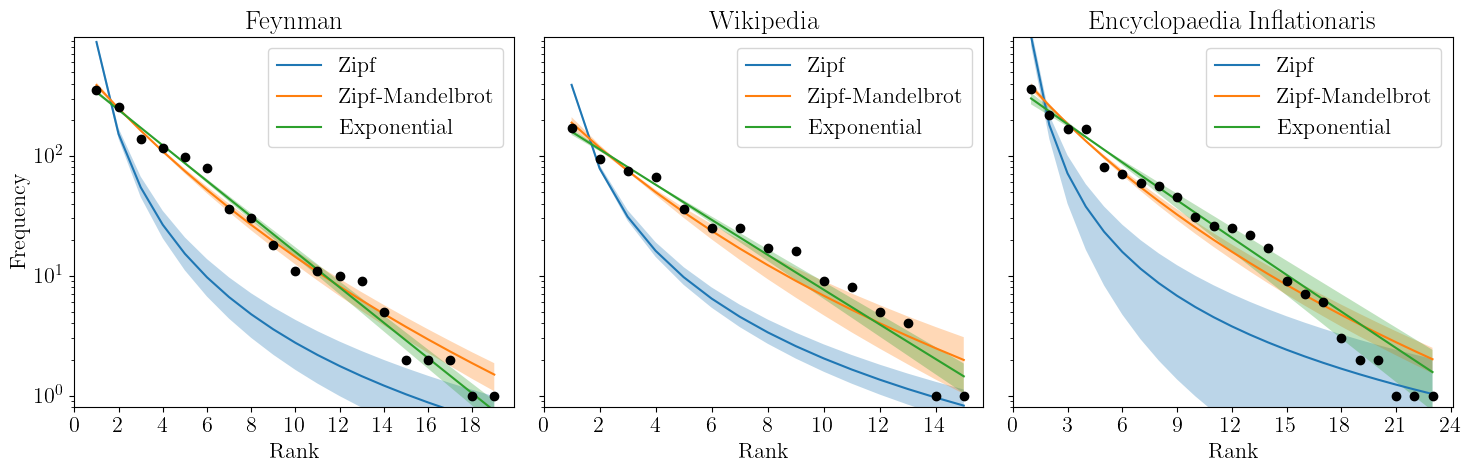

In [90]:
all_run_name = ['feynman', 'wiki', 'inflation']
all_model = ['zipf', 'zipf_mandel', 'exponential']

label_dict = {
    'inflation': 'Encyclopaedia Inflationaris',
    'feynman': 'Feynman',
    'wiki': 'Wikipedia',
    'zipf': 'Zipf',
    'zipf_mandel': 'Zipf-Mandelbrot',
    'exponential': 'Exponential'
}

def zipf(x, alpha):
    return 1 / np.power(x, alpha) / np.sum(1 / np.power(rank, alpha))

def zipf_mandel(x, alpha, b):
    return 1 / np.power(x+b, alpha) / np.sum(1 / np.power(rank+b, alpha))

def exponential(x, beta):
    return np.exp(- beta * x)

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for i, run_name in enumerate(all_run_name):

    print(run_name)

    output_dir = f'results/{run_name}'
    obs = np.loadtxt(f'data/{run_name}_data.txt').astype(int)
    rank = np.arange(1, len(obs)+1)

    for name in all_model:
        
        samples = np.load(f'{output_dir}/{name}_single_samples.npy')
        if name != 'exponential':
            samples = 1 / samples
        print(samples.shape)

        samp_mean = np.mean(samples, axis=0)
        samp_std = np.std(samples, axis=0)
        print(f'\t{name}: {samp_mean} +/- {samp_std}')

        if name == 'zipf':
            fits = np.array([zipf(rank, *s) for s in samples])
        elif name == 'zipf_mandel':
            fits = np.array([zipf_mandel(rank, *s) for s in samples])
        elif name == 'exponential':
            fits = np.array([exponential(rank, *s) for s in samples])
        else:
            raise ValueError('Unknown simulator')
        
        # Normalise the fits
        fits = fits / np.sum(fits, axis=1)[:, None] * obs.sum()

        mean_fit = np.mean(fits, axis=0)
        upper_fit = np.percentile(fits, 84, axis=0)
        lower_fit = np.percentile(fits, 16, axis=0)
        axs[i].plot(rank, mean_fit, label=label_dict[name])
        axs[i].fill_between(rank, lower_fit, upper_fit, alpha=0.3)

        # if name == 'zipf':
        #     samples = np.linspace(0, 3, 10)
        #     fits = np.array([zipf(rank, s) for s in samples])
        #     fits = fits / np.sum(fits, axis=1)[:, None] * obs.sum()
        #     for fit in fits:
        #         axs[i].plot(rank, fit, color='gray', alpha=0.3)

    axs[i].set_ylim(max(0.8, axs[i].get_ylim()[0]), None)
    axs[i].set_xlim(0, None)
    axs[i].set_yscale('log')
    axs[i].set_xlabel('Rank')
    if i == 0:
        axs[i].set_ylabel('Frequency')
    axs[i].legend()
    axs[i].set_title(label_dict[run_name])
    axs[i].plot(rank, obs, 'ko', label='Observed')
    axs[i].xaxis.set_major_locator(MaxNLocator(integer=True))    

fig.tight_layout()
fig.savefig(f'figures/ili_fits.pdf', bbox_inches='tight')

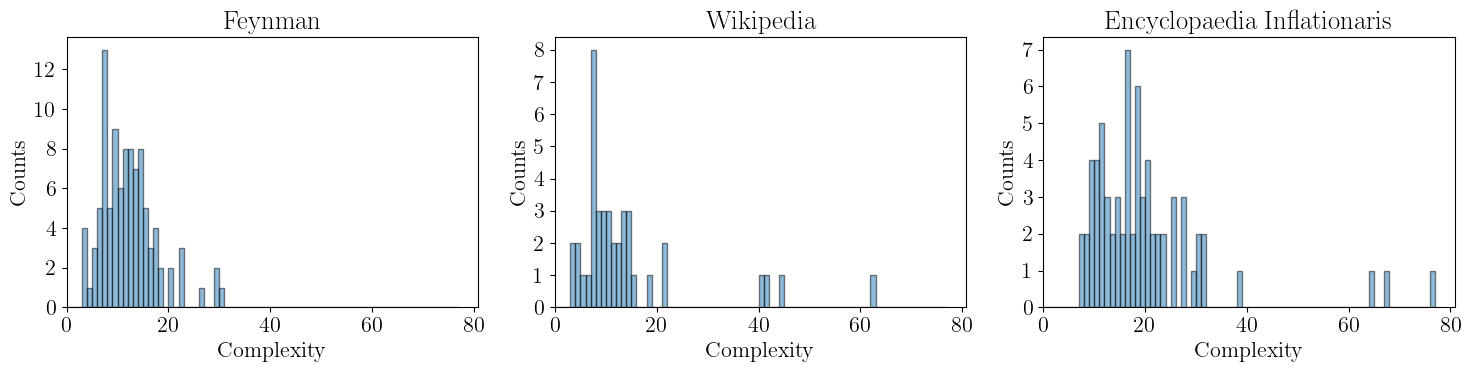

In [53]:
complexity_inflation = [16, 31, 8, 16, 23, 16, 9, 12, 10, 16, 27, 16, 11, 38, 10, 9, 14, 27, \
    25, 13, 19, 20, 14, 8, 77, 25, 22, 7, 18, 14, 10, 30, 18, 22, 17, 29, \
    27, 20, 17, 12, 18, 11, 15, 20, 19, 18, 9, 11, 19, 67, 64, 9, 30, 18, \
    7, 13, 21, 16, 23, 10, 11, 18, 15, 16, 31, 20, 21, 11, 12, 25]

complexity_feynman = [11, 15, 17, 10, 20, 10, 11, 3, 14, 12, 3, 10, 14, 13, 5, 8, 14, 17, \
    12, 12, 11, 6, 8, 18, 3, 5, 9, 3, 17, 15, 6, 14, 29, 7, 7, 16, 7, 13, \
    17, 7, 9, 7, 13, 29, 7, 5, 11, 10, 6, 13, 14, 9, 8, 9, 15, 22, 18, \
    14, 6, 9, 11, 14, 12, 15, 13, 16, 10, 12, 7, 7, 15, 12, 6, 4, 9, 7, \
    9, 9, 13, 20, 12, 22, 7, 7, 7, 16, 22, 11, 11, 30, 11, 7, 14, 12, 10, \
    13, 9, 8, 26, 8]

complexity_wiki = [10, 4, 9, 7, 8, 10, 9, 15, 11, 12, 7, 9, 62, 10, 14, 7, 7, 6, 7, 14, \
    18, 8, 41, 14, 44, 13, 7, 13, 5, 8, 21, 13, 11, 3, 4, 3, 7, 40, 12, \
    21, 7]

complexity_dict = {'inflation': complexity_inflation, 'feynman': complexity_feynman, 'wiki': complexity_wiki}

fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharex=True)
max_complexity = max([max(complexity_dict[run_name]) for run_name in all_run_name])
bins = np.arange(0, max_complexity+1, 1)

for i, run_name in enumerate(all_run_name):
    axs[i].hist(complexity_dict[run_name], bins=bins, density=False, alpha=0.5, histtype='bar', label='Observed', edgecolor='black')
    axs[i].set_xlabel('Complexity')
    axs[i].set_ylabel('Counts')
    axs[i].set_title(label_dict[run_name])
    axs[i].set_xlim(0, None)
    axs[i].yaxis.set_major_locator(MaxNLocator(integer=True))
fig.tight_layout()
fig.align_labels()
fig.savefig(f'figures/complexity_histogram.pdf', bbox_inches='tight')


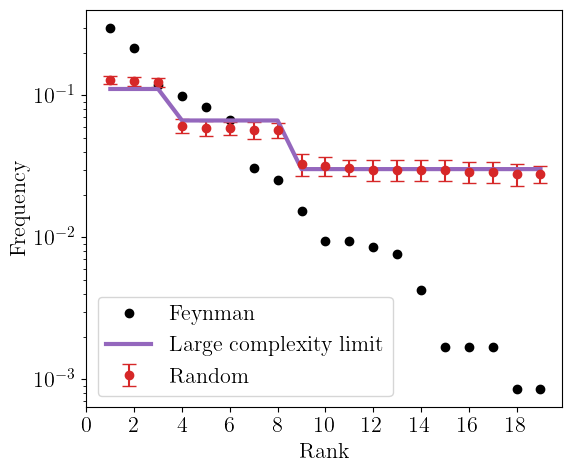

In [52]:
random_means = [0.129, 0.126, 0.124, 0.061, 0.059, 0.059, 0.057, 0.057, 0.033, 0.032, 0.031, 0.030, 0.030, 0.030, 0.030, 0.029, 0.029, 0.028, 0.028]
random_errors = [0.008, 0.009, 0.009, 0.007, 0.007, 0.006, 0.008, 0.007, 0.006, 0.005, 0.004, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.004]
large_complexity_limit = [1/(3*3)] * 3 + [1/(3*5)] * 5 + [1/(3*11)] * 11
obs = np.loadtxt(f'data/feynman_data.txt').astype(int)

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
all_rank = np.arange(len(random_means)) + 1
ax.plot(all_rank, obs/obs.sum(), 'o', label=label_dict['feynman'], color='black')
ax.errorbar(all_rank, random_means, yerr=random_errors, fmt='o', label='Random', color='C3', capsize=5)
ax.plot(all_rank, large_complexity_limit, label='Large complexity limit', color='C4', lw=3)
ax.set_yscale('log')
ax.set_xlim(0, None)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))    
ax.set_xlabel('Rank')
ax.set_ylabel('Frequency')
ax.legend()
fig.tight_layout()
fig.savefig(f'figures/feynman_vs_random.pdf', bbox_inches='tight')

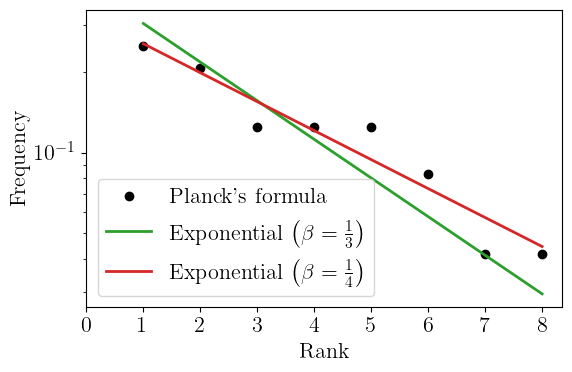

In [96]:
countsPlanck = [(3, "x"), (3, "a"), (5, "c"), (6, "Mult"), (3, "Div"), (1, "Subtract"), (2, "Pow3"),(1, "Exp")]

countsPlanck = np.sort(np.array([cp[0] for cp in countsPlanck])).astype(float)[::-1]
countsPlanck /= countsPlanck.sum()
all_rank = np.arange(len(countsPlanck)) + 1

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(all_rank, countsPlanck, 'o', label="Planck's formula" , color='black')
ax.plot(all_rank, np.exp(-all_rank/3)/np.sum(np.exp(-all_rank/3)), label=r'Exponential $\left( \beta = \frac{1}{3} \right)$', color='C2', lw=2)
ax.plot(all_rank, np.exp(-all_rank/4)/np.sum(np.exp(-all_rank/4)), label=r'Exponential $\left( \beta = \frac{1}{4} \right)$', color='C3', lw=2)
ax.set_xlim(0, None)
ax.set_yscale('log')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))    
ax.set_xlabel('Rank')
ax.set_ylabel('Frequency')
ax.legend(loc='lower left')
fig.tight_layout()
fig.savefig(f'figures/planck_vs_exponential.pdf', bbox_inches='tight')

In [91]:
lnK = np.array([22.1, 16.5, 24.9])
log10K = np.log10(np.exp(lnK))
print(log10K)

lnK = np.array([12.7, 4.0, 2.2])
log10K = np.log10(np.exp(lnK))
print(log10K)

[ 9.59790805  7.16585895 10.8139326 ]
[5.51553992 1.73717793 0.95544786]
